Dataset: https://www.kaggle.com/c/painter-by-numbers/data

Tensorflow Tutorial: https://www.tensorflow.org/tutorials/generative/dcgan



In [2]:
import math
from random import randint
import random
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import sys, os
import time
from IPython import display

In [3]:
dataset_dir = '../Datasets/Painting/'

dataset = pd.read_csv(dataset_dir + 'train_info.csv')
dataset.head()

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0


In [4]:
dataset.shape

(79433, 6)

In [5]:
all_abstract_paintings = dataset[dataset['filename'].str.startswith('1')][dataset['genre'] == 'self-portrait'] 
# picasso [dataset['artist'] == '1950e9aa6ad878bc2a330880f77ae5a1']
all_abstract_paintings

<ipython-input-5-10cea5b5e61a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_abstract_paintings = dataset[dataset['filename'].str.startswith('1')][dataset['genre'] == 'self-portrait']


,filename,artist,title,style,genre,date
473,13889.jpg,acd9b34941d5485b6ffcf6836e07149f,Self portrait at the age of 35,Romanticism,self-portrait,1828
532,10590.jpg,345dc3f45c95d3fe04f8c192cc8ed8d2,Self-portrait as a young man,Romanticism,self-portrait,1800
1294,16134.jpg,3cc9a44380296d93e68b71a27643c25f,Self-Portrait with Beret,Post-Impressionism,self-portrait,1900
1326,100152.jpg,3cc9a44380296d93e68b71a27643c25f,Self-portrait in front of pink background,Impressionism,self-portrait,1875
1426,1680.jpg,397c63db1c7b507d23abff3f8bb0fa18,Self-portrait as the Apostle Paul,Baroque,self-portrait,1661
...,...,...,...,...,...,...
77490,103249.jpg,7b016984b86b58f83977299591cf4e38,SF74-44,Abstract Expressionism,self-portrait,1974
78135,14132.jpg,f6eed0644e89ed34e28ce8dac9fcdcc6,Self-Portrait,Post-Impressionism,self-portrait,NaN
78369,18913.jpg,5dd3541af80138e22424b513b8e5f275,Self-portrait,Expressionism,self-portrait,1932
79296,14830.jpg,16548363e96f1c64ca498fd00352df9a,Self-Portrait,Romanticism,self-portrait,1861


In [19]:
abstract_painting_filename = np.array(all_abstract_paintings['filename'])
image_size = 50

In [24]:
def load_images(selected_images):
    images = []
    for num in range (15):
        for i in selected_images: # 
            image = load_img(dataset_dir + 'train_1/' + abstract_painting_filename[i], color_mode = "grayscale")
            # img = img_to_array(img)
            image = image.resize((image_size, image_size))
            image = img_to_array(image).astype('float32')
            image = (image - 127.5) / 127.5
            # print(image)
            images.append(image)
    
    return images

In [25]:
selected_images = [18, 21, 35, 38, 45, 47, 54]
images = load_images(selected_images)

In [26]:
def plot_images(images, start, end):
    plt.figure(figsize=(10,10))
    for i in range(start, end):
        plt.subplot(5,5,i - start + 1)
        plt.grid(False)
        plt.imshow(images[i], 'gray')
    plt.show()

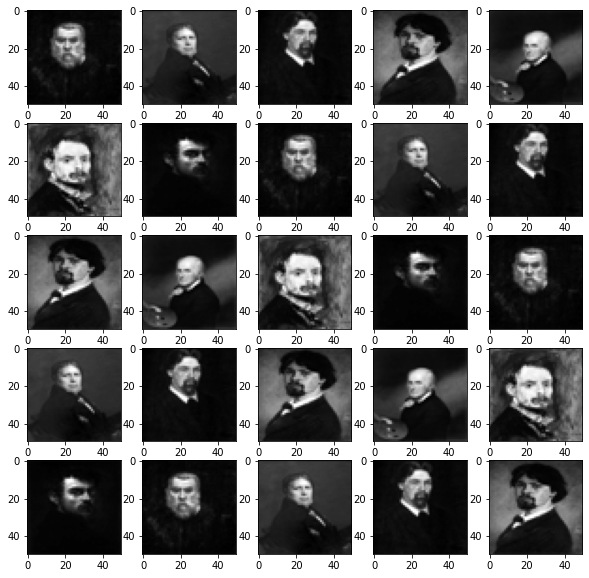

In [27]:
plot_images (images, 0, 25)

In [28]:
BUFFER_SIZE = 1000
BATCH_SIZE = 100

image_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
# Taken from: https://www.tensorflow.org/tutorials/generative/dcgan

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(image_size*image_size, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 1)))
    assert model.output_shape == (None, image_size, image_size, 1) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model

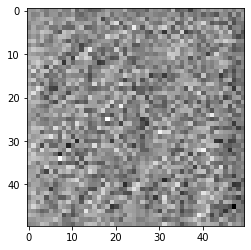

In [30]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# img = Image.fromarray(np.array(generated_image[0]), 'RGB')
plt.imshow(generated_image[0], 'gray')

In [31]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), padding='same', input_shape=[image_size, image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [32]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00225786]], shape=(1, 1), dtype=float32)


In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [38]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [42]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    
    plt.imshow(predictions[0], 'gray')
    
#     img = Image.fromarray(np.array(predictions[0]))
#     plt.imshow(img)

#     for i in range(predictions.shape[0]):
#         plt.subplot(5, 5, i+1)
#         img = Image.fromarray(np.array(predictions[i]), 'RGB')
#         plt.imshow(img)
#         plt.axis('off')

    plt.savefig('portrait-dup/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

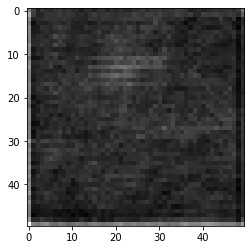

Time for epoch 46 is 93.1123788356781 sec


In [ ]:
train(image_dataset, EPOCHS)